  Stage  WWTP Location  Fine (<0.2 mm)  Medium (0.2−1 mm)  Coarse (>1 mm)
0     I              3              15                 45              40
1     I              4              20                 45              35
2    II              1              20                 40              40
3    II              2              20                 40              40
4    II              3              25                 40              35 

Summary statistics:
                         mean  median       std
Fine (<0.2 mm)     23.928571    20.0  6.256864
Medium (0.2−1 mm)  43.928571    45.0  3.496466
Coarse (>1 mm)     32.142857    35.0  8.254203
WWTP Location       2.642857     3.0  1.150728 



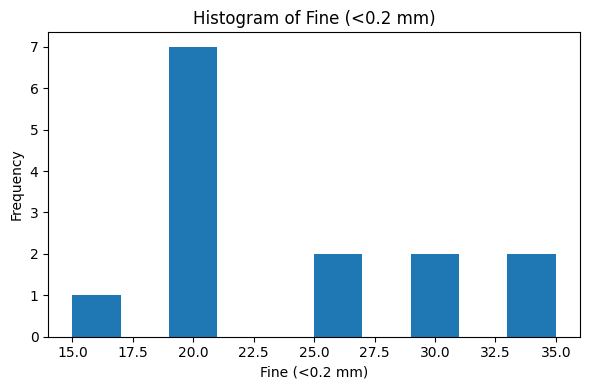

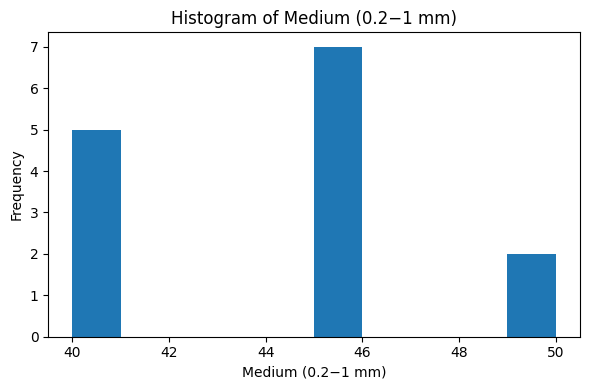

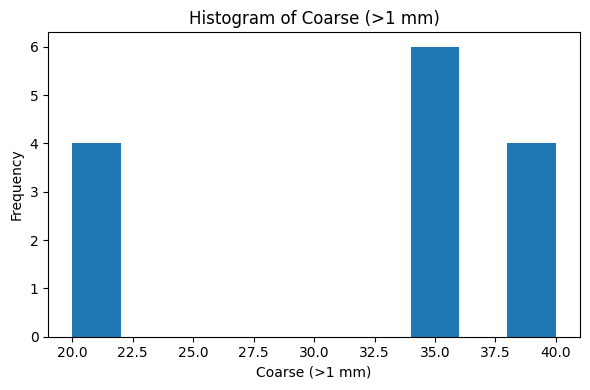

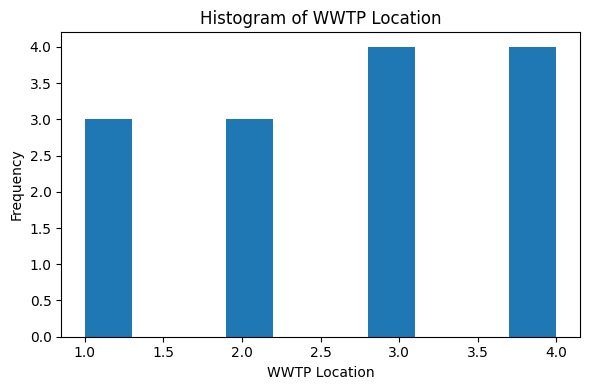

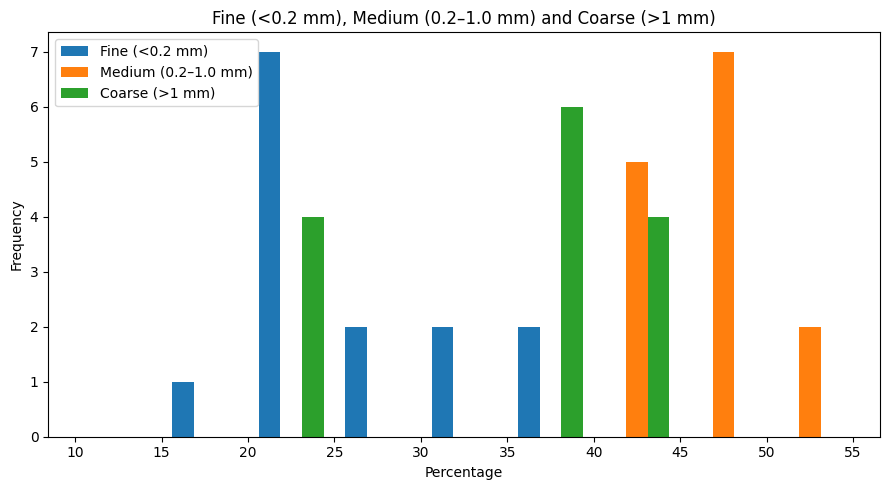

Pearson correlation matrix:
                    Fine (<0.2 mm)  Medium (0.2−1 mm)  Coarse (>1 mm)
Fine (<0.2 mm)           1.000000           0.383012       -0.920265
Medium (0.2−1 mm)        0.383012           1.000000       -0.713930
Coarse (>1 mm)          -0.920265          -0.713930        1.000000 

Spearman correlation matrix:
                    Fine (<0.2 mm)  Medium (0.2−1 mm)  Coarse (>1 mm)
Fine (<0.2 mm)           1.000000           0.294653       -0.854282
Medium (0.2−1 mm)        0.294653           1.000000       -0.694365
Coarse (>1 mm)          -0.854282          -0.694365        1.000000 



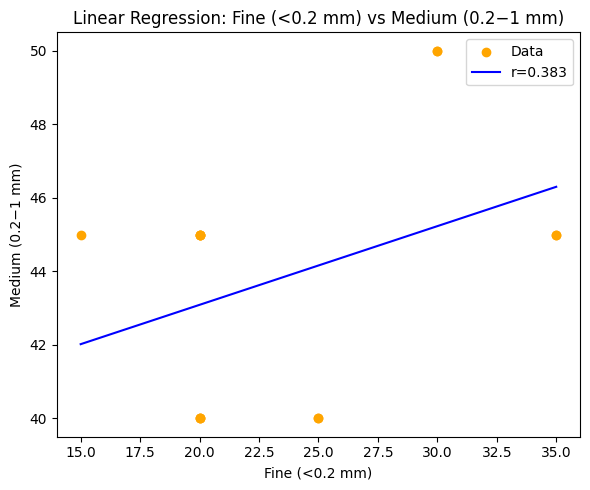

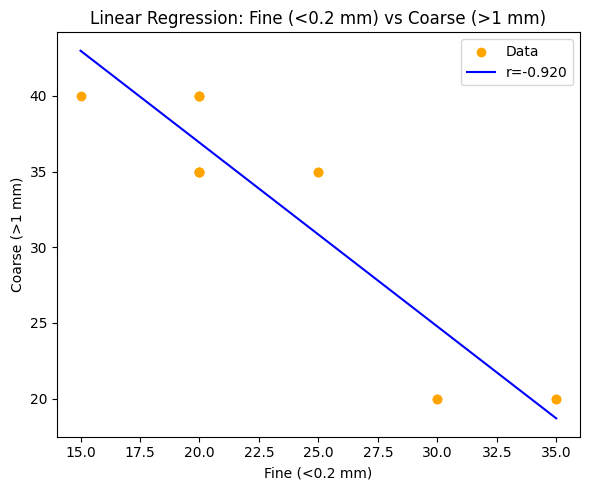

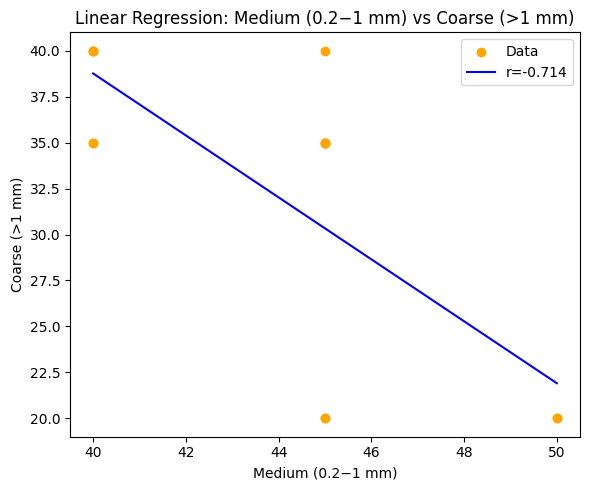

PCA Loadings:
                         PC1       PC2
Fine (<0.2 mm)     0.575535 -0.584100
Medium (0.2−1 mm)  0.499204  0.805293
Coarse (>1 mm)    -0.647730  0.101640 



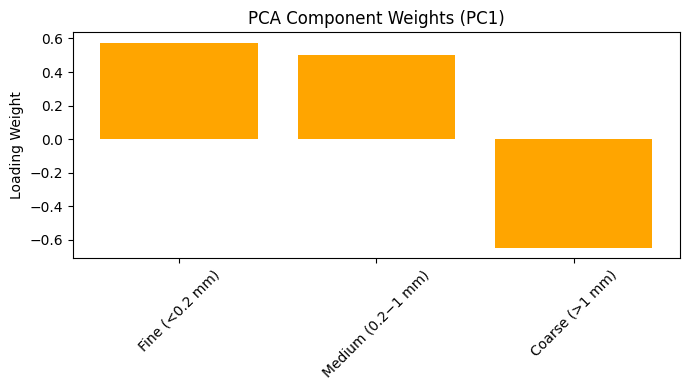

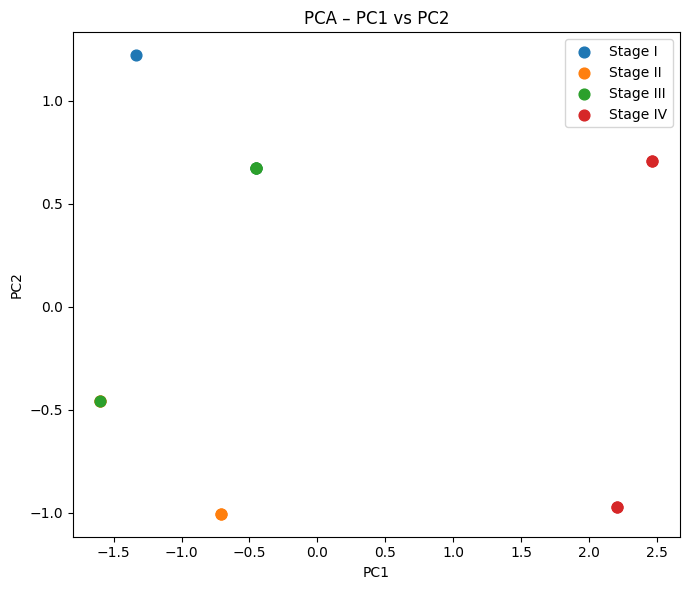

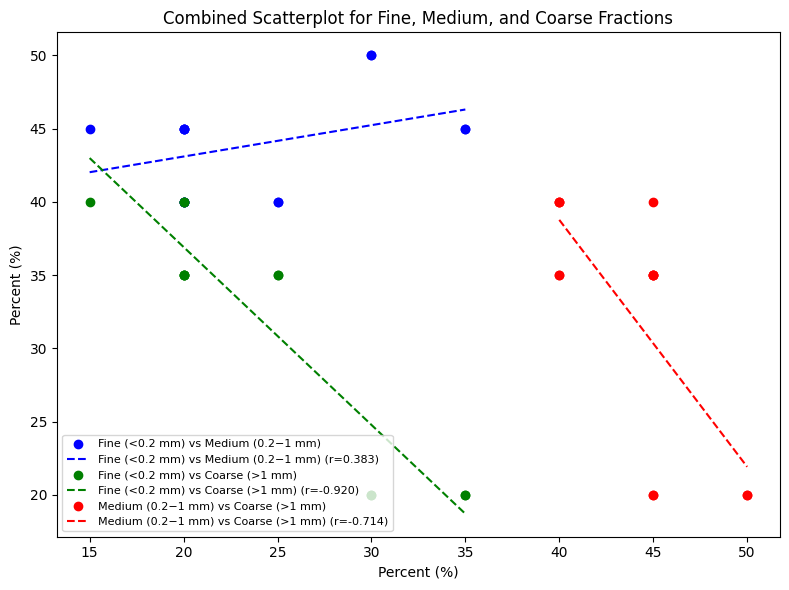

In [6]:
# Size distribution data: main data for paper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

file_path = "size distribution.csv"
df = pd.read_csv(file_path)

# Convert percent-like columns to numeric
percent_cols = ["Fine (<0.2 mm)", "Medium (0.2−1 mm)", "Coarse (>1 mm)"]
for col in percent_cols:
    df[col] = (
        df[col].astype(str)
        .str.replace("%", "", regex=False)
        .str.replace(r"[^0-9.\-]", "", regex=True))
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["Stage"] = df["Stage"].astype("category")

print(df.head(), "\n")


# Statistics
numeric_cols = percent_cols + ["WWTP Location"]

summary_stats = df[numeric_cols].agg(["mean", "median", "std"]).T
print("Summary statistics:\n", summary_stats, "\n")

# Histograms
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=10)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
# Combined histogram for Fine, Medium, and Coarse size fractions (grouped bars)
plt.figure(figsize=(9,5))

# Common bins (same as x-axis ticks in your example)
bins = np.arange(10, 60, 5)          # 10,15,20,...,55
bin_centers = (bins[:-1] + bins[1:]) / 2

# Data
fine_vals   = df["Fine (<0.2 mm)"].dropna()
med_vals    = df["Medium (0.2−1 mm)"].dropna()
coarse_vals = df["Coarse (>1 mm)"].dropna()

# Histogram counts for each fraction
fine_counts, _   = np.histogram(fine_vals,   bins=bins)
med_counts, _    = np.histogram(med_vals,    bins=bins)
coarse_counts,_  = np.histogram(coarse_vals, bins=bins)

# Width of each bar and horizontal offsets so they sit side-by-side
bin_width = bins[1] - bins[0]
bar_width = bin_width / 4.0

plt.bar(bin_centers - bar_width, fine_counts,   width=bar_width,
            label="Fine (<0.2 mm)")
plt.bar(bin_centers,            med_counts,    width=bar_width,
            label="Medium (0.2–1.0 mm)")
plt.bar(bin_centers + bar_width, coarse_counts, width=bar_width,
            label="Coarse (>1 mm)")

plt.xlabel("Percentage")
plt.ylabel("Frequency")
plt.title("Fine (<0.2 mm), Medium (0.2–1.0 mm) and Coarse (>1 mm)")
plt.xticks(bins)
plt.legend()
plt.tight_layout()
plt.show()

# Correlations
pearson_corr = df[percent_cols].corr(method="pearson")
spearman_corr = df[percent_cols].corr(method="spearman")

print("Pearson correlation matrix:\n", pearson_corr, "\n")
print("Spearman correlation matrix:\n", spearman_corr, "\n")


# Linear regressions
pairs = [
    ("Fine (<0.2 mm)", "Medium (0.2−1 mm)"),
    ("Fine (<0.2 mm)", "Coarse (>1 mm)"),
    ("Medium (0.2−1 mm)", "Coarse (>1 mm)")]

for xvar, yvar in pairs:
    clean = df[[xvar, yvar]].dropna()
    x = clean[xvar]
    y = clean[yvar]

    lr = linregress(x, y)

    plt.figure(figsize=(6,5))
    plt.scatter(x, y, label="Data", color="orange")
    
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, lr.slope*xs + lr.intercept, label=f"r={lr.rvalue:.3f}", color="blue")

    plt.xlabel(xvar)
    plt.ylabel(yvar)
    plt.title(f"Linear Regression: {xvar} vs {yvar}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# PCA
X = df[percent_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T,
    index=percent_cols,
    columns=["PC1", "PC2"])

print("PCA Loadings:\n", loadings, "\n")

# Bar chart of PC1
plt.figure(figsize=(7,4))
plt.bar(loadings.index, loadings["PC1"], color="orange")
plt.title("PCA Component Weights (PC1)")
plt.ylabel("Loading Weight")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# PCA Scatterplot
# Color coded by stage
stage_labels = df.loc[X.index, "Stage"]

plt.figure(figsize=(7,6))
for s in stage_labels.unique():
    mask = stage_labels == s
    plt.scatter(pcs[mask, 0], pcs[mask, 1], label=f"Stage {s}", s=60)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – PC1 vs PC2")
plt.legend()
plt.tight_layout()
plt.show()

# Combined scatterplot for Fine, Medium, and Coarse with regression lines
plt.figure(figsize=(8,6))

pairs = [
    ("Fine (<0.2 mm)", "Medium (0.2−1 mm)", "blue"),
    ("Fine (<0.2 mm)", "Coarse (>1 mm)", "green"),
    ("Medium (0.2−1 mm)", "Coarse (>1 mm)", "red")]

for xvar, yvar, color in pairs:
    clean = df[[xvar, yvar]].dropna()
    x = clean[xvar]
    y = clean[yvar]

    # regression
    lr = linregress(x, y)
    xs = np.linspace(x.min(), x.max(), 100)
    ys = lr.slope * xs + lr.intercept

    # scatter
    plt.scatter(x, y, color=color, label=f"{xvar} vs {yvar}")

    # regression line
    plt.plot(xs, ys, color=color, linestyle="--",
             label=f"{xvar} vs {yvar} (r={lr.rvalue:.3f})")

plt.xlabel("Percent (%)")
plt.ylabel("Percent (%)")
plt.title("Combined Scatterplot for Fine, Medium, and Coarse Fractions")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()